In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

# 시스템이 Windows일 경우
if platform.system() == 'Windows':
    plt.rc('font', family='Pretendard')
# macOS일 경우 예시:
elif platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')

# 마이너스 부호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

In [21]:
# 1. 회원정보
features_member = [
    '남녀구분코드',
    '회원여부_이용가능_카드론', '입회경과개월수_신용', '회원여부_연체', '동의여부_한도증액안내',
    '탈회횟수_누적', '탈회횟수_발급1년이내',
    '거주시도명',
    '유효카드수_신용체크', 
    '이용카드수_신용체크', 
    '이용금액_R3M_신용체크', 
    '보유여부_해외겸용_본인', '이용여부_3M_해외겸용_본인',
    '연회비발생카드수_B0M', '기본연회비_B0M', '제휴연회비_B0M'
]

In [3]:
selected_feature=(
    features_member)

In [5]:
print(len(selected_feature))         
print(type(selected_feature[0]))     
# 171 --> 119

16
<class 'str'>


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# 1. 데이터 불러오기
df = pd.read_parquet("../../data/통합_train_데이터.parquet")

# 2. 피처 및 타겟 분리
X = df[selected_feature].copy()
y = df["Segment"]

# 3. 범주형 인코딩
cat_cols = X.select_dtypes(include='object').columns.tolist()
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# 4. 결측치 처리
X = pd.DataFrame(SimpleImputer(strategy='mean').fit_transform(X), columns=X.columns)

# 스케일링 (DataFrame 형태 유지)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# 라벨인코딩
le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)

# 6. train-validation 분할
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# 7. XGBoost 모델 선언 (GPU 가속)
xgb_model = XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# 8. 학습
xgb_model.fit(X_train, y_train)

# 9. 예측 및 평가
y_pred = xgb_model.predict(X_val)
print(classification_report(y_val, y_pred))


c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:06:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:06:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\somee\anaconda3\Lib\site-packages\xgboost\core.py:2676: UserWarning: [15:06:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.s

              precision    recall  f1-score   support

           0       0.86      0.06      0.12       194
           1       1.00      0.10      0.19        29
           2       0.64      0.36      0.46     25518
           3       0.56      0.42      0.48     69848
           4       0.90      0.96      0.93    384411

    accuracy                           0.85    480000
   macro avg       0.79      0.38      0.44    480000
weighted avg       0.83      0.85      0.84    480000



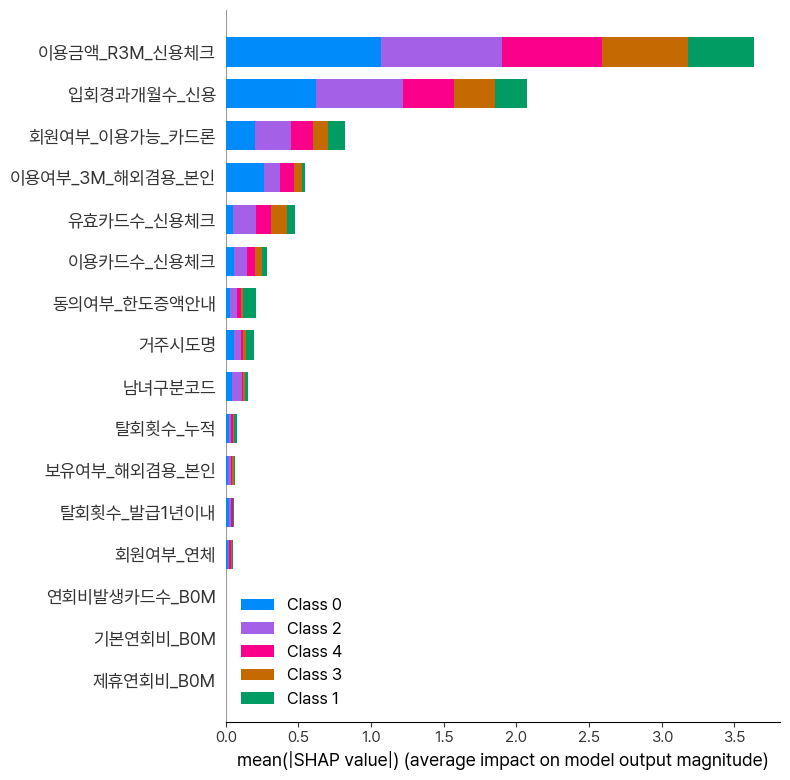

In [7]:
import shap

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_val)

shap.summary_plot(shap_values, X_val, plot_type="bar")

In [12]:
import pandas as pd

importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": xgb_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

display(importance_df.head(30))

,Feature,Importance
10,이용금액_R3M_신용체크,0.522822
9,이용카드수_신용체크,0.114475
2,입회경과개월수_신용,0.089579
12,이용여부_3M_해외겸용_본인,0.075812
1,회원여부_이용가능_카드론,0.052720
8,유효카드수_신용체크,0.029971
4,동의여부_한도증액안내,0.029424
11,보유여부_해외겸용_본인,0.021502
3,회원여부_연체,0.015426
13,연회비발생카드수_B0M,0.009616


 99%|===================| 962/970 [00:45<00:00]        

🔍 SHAP beeswarm plot for Segment 0


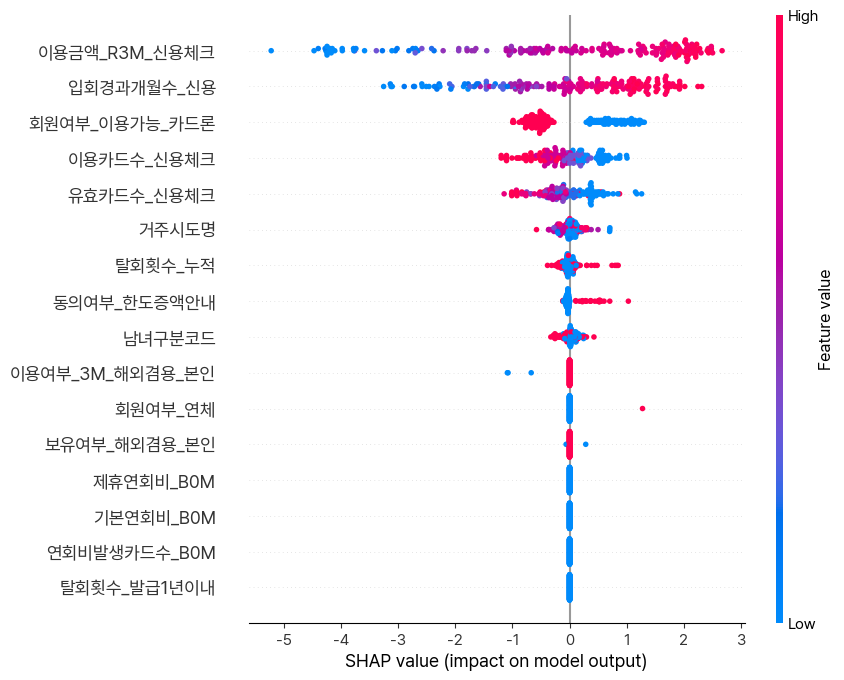

🔍 SHAP beeswarm plot for Segment 1


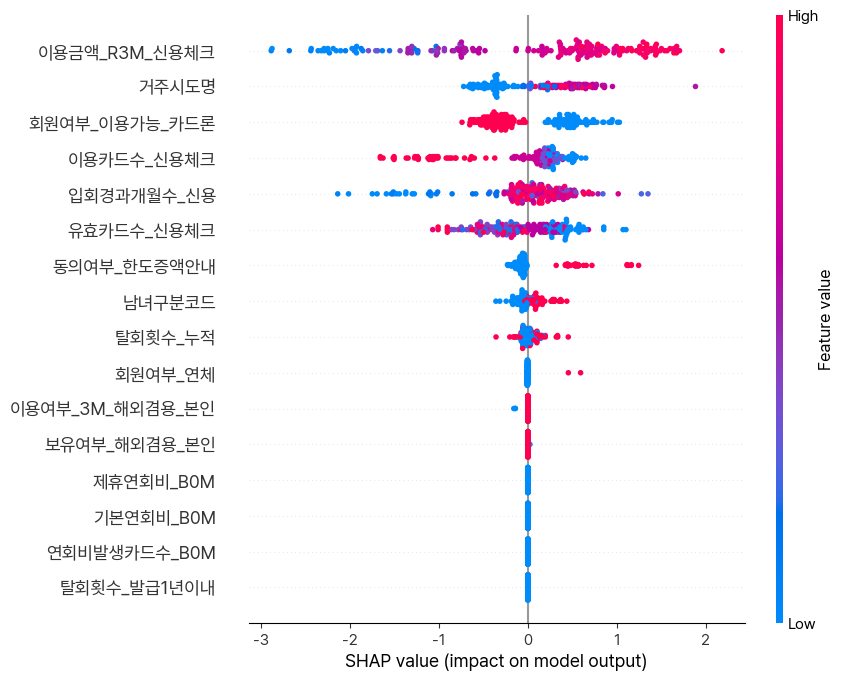

🔍 SHAP beeswarm plot for Segment 2


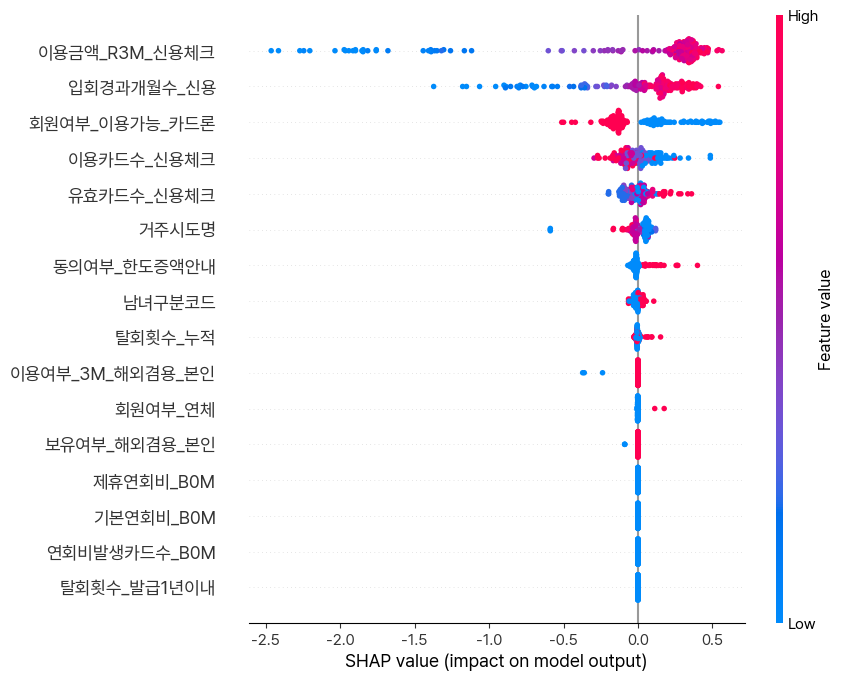

🔍 SHAP beeswarm plot for Segment 3


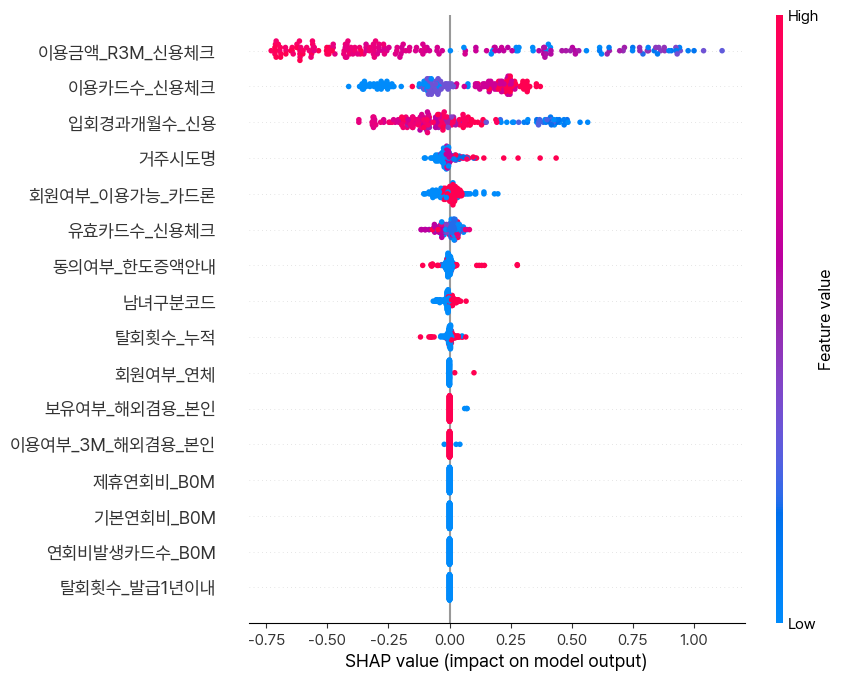

🔍 SHAP beeswarm plot for Segment 4


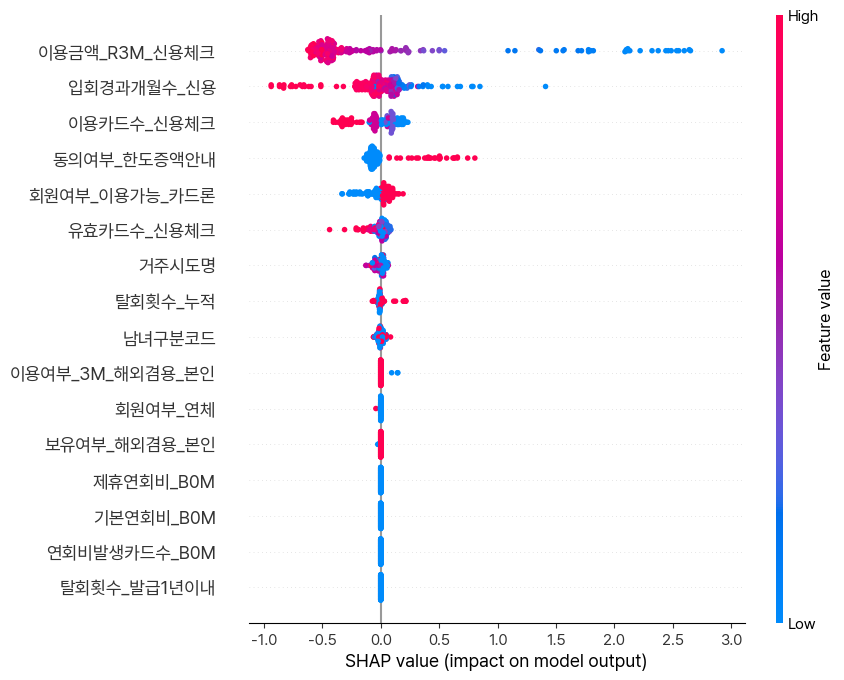

In [14]:
import shap  
import pandas as pd

# Segment 0 마스킹 + 데이터 준비
mask_0 = y_val == 0
X_val_df = pd.DataFrame(X_val, columns=selected_feature)
X_val_0_all = X_val_df[mask_0]

# 샘플 수 조정
n_samples = min(len(X_val_0_all), 300)
X_val_0 = X_val_0_all.sample(n=n_samples, random_state=42)

# SHAP 해석
explainer = shap.Explainer(xgb_model, X_val_0)
shap_values_0 = explainer(X_val_0)

for i in range(5):  # Segment 0 ~ 4
    print(f"🔍 SHAP beeswarm plot for Segment {i}")
    shap.plots.beeswarm(shap_values_0[:, :, i], max_display=20)

1. 회원정보 : 이용금액_R3M_신용체크, 이용카드수_신용체크, 입회경과개월수_신용
- A
신용체크 이용금액 높음 / 낮은사람이 절대 아님
입회경과개월수도 높음 / 낮은사람 절대 아님

- B
이용금액신용체크 낮은사람 절대 아님
이용카드수 신용체크 높은사람 아님 << 확인해봐야할듯? 카드수 적다
입회경과개월수 낮은사람 아님 (장기이용)

- C
이용금액 신용체크 낮은사람 아님
입회경과개월수 낮은사람 아닌경향 (-1.5이하)

- D
C 와 E 사이의 사람들인듯 뚜렷한값 X 이용금액 대체로 평균 -1~1사이

- E
이용금액 신용체크 낮은사람

In [23]:
import pandas as pd

# 1. Parquet 파일 불러오기
file_path = "../../data/merged/회원정보_train.parquet"
df = pd.read_parquet(file_path)

# 2. 키워드가 포함된 컬럼만 필터링
keywords = ["이용금액_", "이용카드수_", "입회경과개월수_"]
selected_cols = [col for col in df.columns if any(k in col for k in keywords)]

# 3. 선택된 컬럼만 추출한 데이터프레임 생성
df_selected = df[selected_cols].copy()

# 4. 결과 출력
print(f"선택된 컬럼 수: {len(selected_cols)}")
print("컬럼 목록:", selected_cols)
print(df_selected.head())


선택된 컬럼 수: 11
컬럼 목록: ['입회경과개월수_신용', '이용카드수_신용체크', '이용카드수_신용', '이용카드수_신용_가족', '이용카드수_체크', '이용카드수_체크_가족', '이용금액_R3M_신용체크', '이용금액_R3M_신용', '이용금액_R3M_신용_가족', '이용금액_R3M_체크', '이용금액_R3M_체크_가족']
   입회경과개월수_신용  이용카드수_신용체크  이용카드수_신용  이용카드수_신용_가족  이용카드수_체크  이용카드수_체크_가족  \
0          67           1         1            0         0            0   
1          12           1         1            0         0            0   
2         124           1         1            0         0            0   
3          27           1         1            0         0            0   
4           2           1         0            0         1            0   

   이용금액_R3M_신용체크  이용금액_R3M_신용  이용금액_R3M_신용_가족  이용금액_R3M_체크  이용금액_R3M_체크_가족  
0            196          196               0            0               0  
1          13475        13475               0            0               0  
2          23988        23988               0            0               0  
3           3904         3904               0          

In [6]:
df_selected = df[selected_cols].copy()

# 결측치 처리 (평균 대체)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
df_selected_imputed = pd.DataFrame(imputer.fit_transform(df_selected), columns=selected_cols)

In [31]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# VIF 계산 함수
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data.sort_values(by="VIF", ascending=False)

vif_result = calculate_vif(df_selected_imputed)
print(vif_result)

c:\Users\somee\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\somee\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


           Feature           VIF
1       이용카드수_신용체크           inf
2         이용카드수_신용           inf
4         이용카드수_체크           inf
6    이용금액_R3M_신용체크  1.791020e+10
7      이용금액_R3M_신용  1.544010e+10
9      이용금액_R3M_체크  1.285868e+09
8   이용금액_R3M_신용_가족  1.444262e+01
3      이용카드수_신용_가족  1.418773e+01
0       입회경과개월수_신용  1.680552e+00
5      이용카드수_체크_가족           NaN
10  이용금액_R3M_체크_가족           NaN


In [25]:
drop_cols = [
    '이용카드수_신용체크', '이용카드수_신용', '이용카드수_체크',
    '이용금액_R3M_신용체크', '이용금액_R3M_신용', '이용금액_R3M_체크',
    '이용카드수_신용_가족', '이용금액_R3M_신용_가족', '이용카드수_체크_가족'
]

In [28]:
# 고다중공선성 제거
df_reduced = df_selected.drop(columns=drop_cols)
col_reduced = df_reduced.columns.tolist()

In [29]:
# 두 리스트 합치기
final_features = features_member + col_reduced

In [38]:
# object 타입 컬럼 리스트 확인
invalid_cols = X_train.select_dtypes(exclude=["float", "int"]).columns.tolist()
print("❌ 문제 컬럼들:", invalid_cols)

❌ 문제 컬럼들: []


In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# 1. 데이터 불러오기
df = pd.read_parquet("../../data/통합_train_데이터.parquet")

# 2. 피처 및 타겟 분리
X = df[final_features].copy()
y = df["Segment"]

# 3. 범주형 인코딩
cat_cols = X.select_dtypes(include='object').columns.tolist()
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# 4. 결측치 처리
X = pd.DataFrame(SimpleImputer(strategy='mean').fit_transform(X), columns=X.columns)

# 스케일링 (DataFrame 형태 유지)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# 라벨인코딩
le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)

# 6. train-validation 분할
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# 7. XGBoost 모델 선언 (GPU 가속)
xgb_model = XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# 강제 float 변환
X_train = X_train.astype("float32")
X_val = X_val.astype("float32")

xgb_model.fit(X_train.values, y_train)
y_pred = xgb_model.predict(X_val.values)
print(classification_report(y_val, y_pred))


c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:05:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:05:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\somee\anaconda3\Lib\site-packages\xgboost\core.py:2676: UserWarning: [16:05:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.s

              precision    recall  f1-score   support

           0       0.86      0.06      0.12       194
           1       1.00      0.14      0.24        29
           2       0.64      0.36      0.46     25518
           3       0.57      0.42      0.48     69848
           4       0.90      0.96      0.93    384411

    accuracy                           0.85    480000
   macro avg       0.79      0.39      0.45    480000
weighted avg       0.83      0.85      0.84    480000

